In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [32]:
augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor()
])

In [33]:
class SSLDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img, _ = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

In [34]:
base_dataset = datasets.CIFAR10(root='./cifar10', train=True, download=True)
ssl_dataset = SSLDataset(base_dataset=base_dataset, transform=augmentation)
dataloader = DataLoader(dataset=ssl_dataset, batch_size=16, shuffle=True)


Files already downloaded and verified


In [35]:
for img1, img2 in dataloader:
    print(img1.shape, img2.shape)
    break

torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32])


In [36]:
class ssl_model(nn.Module):
    def __init__(self, base_encoder, feature_dim=128):
        super().__init__()
        self.encoder = base_encoder
        self.feature_dim = feature_dim
        self.encoder.fc = nn.Identity()
        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim)
        )
    
    def forward(self, x):
        h = self.encoder(x)
        out= self.projection(h)
        return F.normalize(out, dim=1)

In [37]:
def contrastive_loss(z1, z2, temperature=0.5):
    batch_size = z1.size(0)
    z1, z2 = F.normalize(z1,dim=1), F.normalize(z2, dim=1)

    sim_matrix = (z1 @ z2.T)/temperature

    labels = torch.arange(0, batch_size).to(z1.device)
    loss1 = F.cross_entropy(sim_matrix, labels)
    loss2 = F.cross_entropy(sim_matrix.T, labels)
    return (loss1 + loss2)/2

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

encoder = models.resnet18(pretrained=False)
model = ssl_model(encoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

Using device: cuda


C:\Users\mayan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mayan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [41]:
epochs = 5


for epoch in range(epochs):
    total_loss = 0
    for img1, img2 in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        img1, img2 = img1.to(device), img2.to(device)
        z1, z2 = model(img1), model(img2)
        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(dataloader):.4f}")
    


Epoch [1/5] Loss: 2.1615


Epoch [2/5] Loss: 1.9401


Epoch [3/5] Loss: 1.8685


Epoch [4/5] Loss: 1.8247


Epoch [5/5] Loss: 1.7886


In [43]:
encoder.eval()
embeddings = encoder(torch.randn(10, 3, 32, 32).to(device))
print(embeddings)
print(embeddings.shape)

tensor([[11.8956,  0.0000,  4.1875,  ...,  0.0000,  0.0000,  0.0000],
        [12.9802,  0.0000,  3.9722,  ...,  0.0000,  0.0000,  0.0000],
        [ 8.6505,  0.0000,  8.3821,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [12.1100,  0.0000,  9.9017,  ...,  0.0000,  0.0000,  0.0000],
        [ 5.4509,  0.0000,  4.2205,  ...,  0.0000,  0.0000,  0.0000],
        [12.2686,  0.0000,  6.2323,  ...,  0.0000,  1.2629,  0.0000]],
       device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([10, 512])


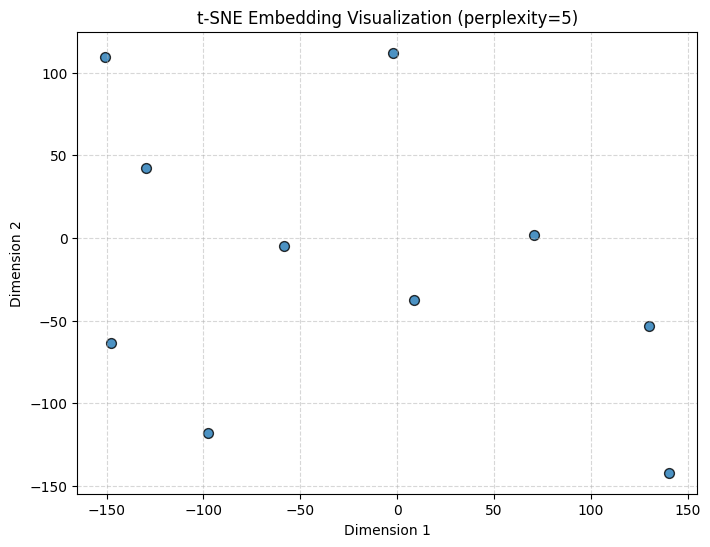

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

emb = embeddings.detach().cpu().numpy()

# Adjust perplexity: must be < number of samples
perplexity = min(5, len(emb) - 1)  # automatically handles small batches
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=50, alpha=0.8, edgecolors='k')
plt.title(f"t-SNE Embedding Visualization (perplexity={perplexity})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
